# This notebook shows pre-processing part of OCR recognition

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import argparse
from PIL import Image
from PIL import ImageFilter
from pylab import *
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
import cPickle
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage import restoration
from skimage import measure
from skimage.color import label2rgb
import matplotlib.patches as mpatches

DENOISING IMAGE

http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html

In [2]:
#Funkcija kao ulaz uzima grayscale sliku a kao izlaz daje grayscale slike
def denoise(image):
    #Parametri funkcije su ulazna slike, h=3 - regulira snagu filtra, velicina prozora,
    # te velicina search prozora - Size in pixels of the window that is used to compute weighted average for given pixel. 
    #Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. 
    #Recommended value 21 pixels
    output=cv2.fastNlMeansDenoising(image,3,7,21)
    return output

BINARISATION

In [3]:
def binarize(img):
    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    #http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    ##KORISTI SE LOKALNO IZJEDNACANJE HISTOGRAMA
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(cl1, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return cl1,thresh

In [4]:
def calculateAngle(thresh):
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    return angle

In [5]:
# rotate the image to deskew it
def rotateImage(image,angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def rotate(image):
    gray,thresh = binarize(image)
    angle = calculateAngle(thresh)
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

LINE REMOVAL

In [6]:
def lineRemoval(image):
    img=image
    laplacian = cv2.Laplacian(img,cv2.CV_8UC1) # Laplacian OR
    edges = cv2.Canny(img,80,10,apertureSize = 3) # canny Edge OR
    # Output dtype = cv2.CV_8U # Sobel
    sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
    # Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)

    # Hough's Probabilistic Line Transform 
    minLineLength = 900
    maxLineGap = 100
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    if lines != None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)
    return img

In [7]:
#Funkcija uzima kao ulaz sliku
def connectedComponents(image):
    #binariziraj sliku
    gray,thresh = binarize(image)
    #Ova funkcija kao ulaz uzima binarnu sliku te parametar da li gleda 4 ili 8 susjedstvo te vrstu izlazne slike
    connectivity=4
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
    return output

In [8]:
#Funkcija za racunanje centra konture
def getCenters(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx,cy

In [9]:
def getTextCandidates(image):
    #binarize image
    gray, thresh = binarize(denoise(img))
    #get contours od the binary image
    _,contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_TC89_KCOS)
    #sort contours by size - largest to smallest
    contours = sorted(contours, key=cv2.contourArea,reverse=True)
    #Calculate bounding boxes for contours
    bounding_boxes = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        bounding_boxes.append([x, y, w, h])
    #Return bounding boxes as a list of candidates
    return bounding_boxes

UCITAVANJE SLIKE - ODAVDE POCINJE PROCES

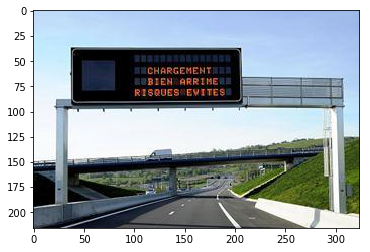

In [10]:
#img = cv2.imread('./imposed.png')
#img = cv2.imread('./sceneembeddedtext.png')
img = cv2.imread('./image.png')
#img = cv2.resize(img, (0,0), fx=3, fy=3) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

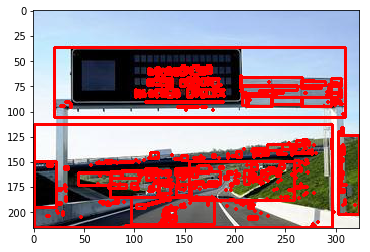

In [11]:
imgcont2 = img.copy()
contours=getTextCandidates(img)
for c in contours:
    (x, y, w, h) = c
    cv2.rectangle(imgcont2,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(imgcont2)
plt.show()

bounding_boxes = []
candidates = []
#Kandidati za klasifikaciju
for c in contours:
    (x, y, w, h) = c
    cv2.rectangle(imgcont2,(x,y),(x+w,y+h),(255,0,0),2)
    #candidates.append(np.resize(imgcont2[x:x+w,y:y+h], (30,30)))
    candidates.append(img[x:x+w,y:y+h])

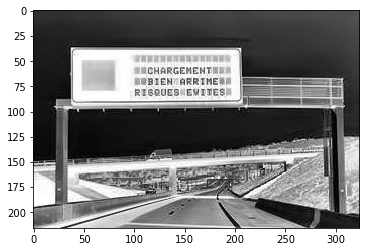

In [16]:
gray, thresh = binarize(denoise(img))
plt.imshow(gray,'gray')
plt.show()